In [ ]:
# Torch
import torch
import torch.optim as optim
from torcheval.metrics import *

import pickle
from captum.attr import *
import random
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Custom modules
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *
from ozzy_torch_utils.plot import *
from ozzy_torch_utils.train_nn import *
from ozzy_torch_utils.model_parameters import *
from ozzy_torch_utils.init_dataloaders import *
from explain_pointnet import *

In [ ]:
# Load model
pickle_pathname = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/runs/run_18-03-2025_15-35-05/run_18-03-2025_15-35-05_params.pkl"

with open(pickle_pathname, 'rb') as file:
    
    model_parameters = pickle.load(file)
    
model = model_parameters.model

In [ ]:
# Load dataset
data_path = "/uolstore/home/users/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort"

subject_list = find_subjects_parallel(data_path)

Interesting experiment comparing attributions from two permutations of the same cloud

In [ ]:
subject = sample(subject_list, 1)[0]

cloud = np.load(os.path.join(subject.path, "Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy"))
    

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

attributions_orig, pred_research_group_orig = pointnet_ig(model, cloud, device)

shuffler = np.random.permutation(cloud.shape[0])

unshuffler = np.argsort(shuffler)

cloud_shuffled = np.array([cloud[i] for i in shuffler])

attributions_shuffled, pred_research_group_shuffle = pointnet_ig(model, cloud_shuffled, device)

cloud_unshuffled = np.array([cloud_shuffled[i] for i in unshuffler])

attributions_unshuffled = np.array([attributions_shuffled[i] for i in unshuffler])

attributions_diff = attributions_orig - attributions_unshuffled

print(attributions_diff)

if pred_research_group_orig != pred_research_group_shuffle:
    
    print("Research groups are different after shuffle")
    

In [41]:
def vis_attributions(attributions, subject, cloud, pred_research_group):
    
    # Sum x, y and z values for an overall attribution for that point
    xyz_sum = np.sum(attributions, axis=1)

    def power_transform(data, power):

        return np.sign(data) * np.power(np.abs(data), power)

    plt.plot(xyz_sum)

    plt.show()

    xyz_sum = power_transform(xyz_sum, 0.1)

    plt.plot(xyz_sum)

    plt.show()

    # Normalise such that 0 attribution maps to 0.5 and the relative sizes of positive and negative attributions is preserved
    def norm(data):

        min = np.min(data)
        max = np.max(data)

        max_abs_val = np.max((np.abs(min), np.abs(max)))

        return np.array([0.5 + (value / (2 * max_abs_val)) for value in data])


    norm_xyz_sum = norm(xyz_sum)

    plt.plot(norm_xyz_sum)

    plt.show()

    # Have to use custom cmap to force the 0 attributions to be white
    colours = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours)

    pv_cloud = pv.PolyData(cloud)

    plotter = pv.Plotter()

    plotter.add_points(pv_cloud, scalars=norm_xyz_sum, cmap=custom_cmap, clim= [0,1])

    plotter.set_background("black")

    # THIS IS NOT FOR USE, IT IS RUNNING PREDICTIONS ON TRAINING DATA!!
    plotter.add_text("This is just a test running on training data!", color='white')
    plotter.add_text(f"True class: {str(subject.subject_metadata['Group'].iloc[0])} \n Predicted class: {pred_research_group} ", color='white', position='upper_right')

    plotter.show()
    
    return

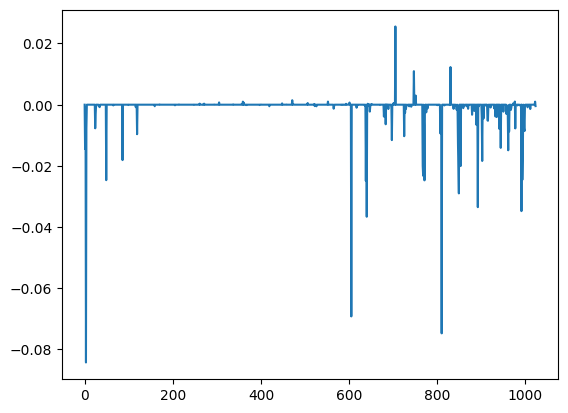

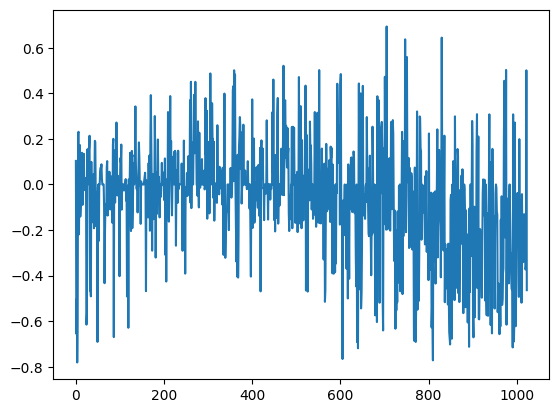

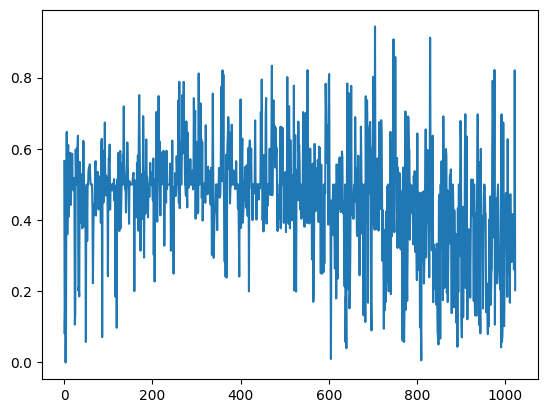

Widget(value='<iframe src="http://localhost:39689/index.html?ui=P_0x7f37c07149e0_11&reconnect=auto" class="pyv…

In [42]:
vis_attributions(attributions_orig, subject, cloud, pred_research_group_orig)

#vis_attributions(attributions_shuffled, subject, cloud_shuffled, pred_research_group_shuffle)

#vis_attributions(attributions_unshuffled, subject, cloud_unshuffled, pred_research_group_shuffle)

#vis_attributions(attributions_diff, subject, cloud, pred_research_group_orig)